In [1]:
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)
print("Tokenizer loaded successfully.")

Tokenizer loaded successfully.


In [3]:
lstm_model = load_model("lstm_model.h5")
print("LSTM model loaded successfully.")

LSTM model loaded successfully.


In [5]:
import joblib

nb_model = joblib.load("model_pipeline.pkl")
lr_model = joblib.load("model_pipeline_lr.pkl")
svm_model = joblib.load("model_pipeline_svm.pkl")
xgb_model = joblib.load("model_pipeline_xgb.pkl")

print("All classical ML models loaded successfully.")


All classical ML models loaded successfully.


In [10]:
def coerce_binary_labels(arr):
    """Coerce labels to {0,1}."""
    arr = np.asarray(arr)
    if arr.dtype.kind in {"i", "u", "b", "f"}:  # numeric
        # Map any nonzero to 1 and zero to 0 for safety
        return (arr.astype(float) > 0.0).astype(int)
    # string/object - convert "0"/"1" strings
    out = []
    for v in arr:
        if v is None or (isinstance(v, float) and np.isnan(v)):
            out.append(0)
            continue
        s = str(v).strip()
        if s == "0":
            out.append(0)
        elif s == "1":
            out.append(1)
        else:
            raise ValueError(f"Unrecognized label value: {v}, expected 0 or 1")
    return np.array(out, dtype=int)

In [11]:
# Build shared test split once
X_train, X_test, y_train, y_test = load_binary_true_fake_dataset(test_size=0.2, random_state=42)
print(f"Dataset prepared. Train: {len(X_train)}, Test: {len(X_test)}")

Dataset prepared. Train: 35918, Test: 8980


In [12]:
# Evaluate all models consistently
results = []
results.append(evaluate_sklearn_pipeline(nb_model, X_test, y_test, name="Naive Bayes"))
results.append(evaluate_sklearn_pipeline(lr_model, X_test, y_test, name="Logistic Regression"))
results.append(evaluate_sklearn_pipeline(svm_model, X_test, y_test, name="SVM"))
results.append(evaluate_sklearn_pipeline(xgb_model, X_test, y_test, name="XGBoost"))
results.append(evaluate_lstm(lstm_model, tokenizer, X_test, y_test, name="LSTM", max_len=MAX_LEN))
df_results = pd.DataFrame(results)
df_results.sort_values(by=["F1","Accuracy"], ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results

,Model,Accuracy,Precision,Recall,F1,Predict Time (s),ms/sample,Train Time (s)
0,XGBoost,0.996882,0.996827,0.996927,0.996876,7.351928,0.818700,None
1,SVM,0.993318,0.993390,0.993222,0.993303,1.577101,0.175624,None
2,Logistic Regression,0.981069,0.980815,0.981388,0.981042,3.677675,0.409541,None
3,Naive Bayes,0.951448,0.951226,0.951530,0.951362,3.701955,0.412244,None
4,LSTM,0.829733,0.875522,0.821668,0.821603,4.272081,0.475733,None


Best model: XGBoost
Saved results to: d:\QuickFactChecker\results\ml_comparison_results.csv
d:\QuickFactChecker\results\ml_comparison_results.md


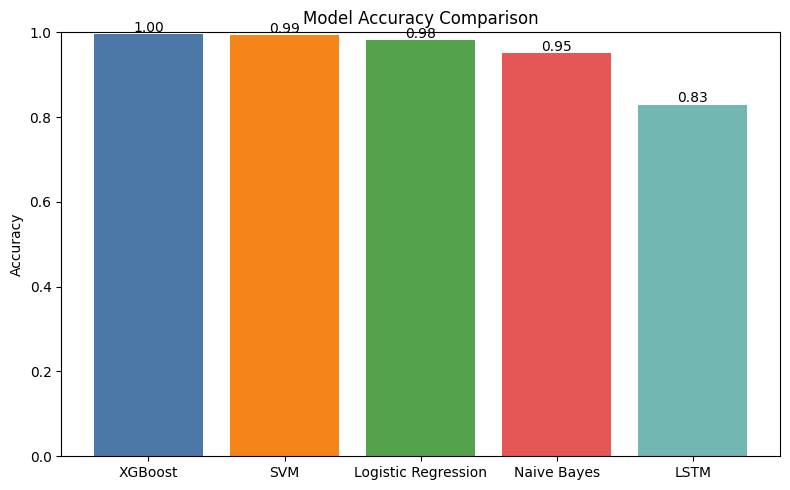

In [9]:
# Persist results and visualize
best_name = df_results.loc[0, "Model"]
print("Best model:", best_name)
df_results_rounded = df_results.copy()
for col in ["Accuracy", "Precision", "Recall", "F1", "Predict Time (s)", "ms/sample"]:
    if col in df_results_rounded.columns:
        df_results_rounded[col] = df_results_rounded[col].astype(float).round(4)
csv_path = RESULTS_DIR / "ml_comparison_results.csv"
md_path = RESULTS_DIR / "ml_comparison_results.md"
png_path = RESULTS_DIR / "ml_comparison_accuracy.png"
df_results_rounded.to_csv(csv_path, index=False)
with open(md_path, "w", encoding="utf-8") as f:
    f.write("# Model Comparison Results\n\n")
    f.write(as_markdown_table(df_results_rounded[["Model","Accuracy","Precision","Recall","F1","Predict Time (s)","ms/sample"]]))
print(f"Saved results to: {csv_path}\n{md_path}")
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.bar(df_results["Model"], df_results["Accuracy"], color=["#4C78A8", "#F58518", "#54A24B", "#E45756", "#72B7B2"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
for i, acc in enumerate(df_results["Accuracy"]):
    plt.text(i, acc + 0.005, f"{acc:.2f}", ha='center')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig(png_path, dpi=150)
plt.show()